In [3]:
import pybaseball
import pandas as pd
import numpy as np
import bs4
import requests
import matplotlib.pyplot as plt
import unicodedata
import seaborn as sns
import math
import matplotlib.patches as mpatches

In [4]:
pybaseball.cache.enable()

import os
pd.set_option('display.max_columns',None)
os.getcwd()
os.chdir('C:\\Users\\npacchioli\\Desktop\\pitching\\')
os.getcwd()

directory = 'C:\\Users\\npacchioli\\Desktop\\pitching\\'

In [5]:
#load json data
def load_data():
    #with open('statcast_data_2023.json', 'r') as file:
    #    data = json.load(file)
        
    #df = pd.DataFrame(data)
    df = pd.read_json('statcast_data_2023.json', lines=True)
    return df

df23 = load_data()

# All My Definitions


### Standards 

In [6]:
monthTable23 = pd.DataFrame({'Month': ['2023-03','2023-04','2023-05','2023-06','2023-07','2023-08','2023-09', '2023-10'],
                           'Abbrev': ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct'],
                          'Months': ['Mar-Jun','Mar-Jun','Mar-Jun','Mar-Jun','Jul-Oct','Jul-Oct','Jul-Oct','Jul-Oct']})


def create_date_columns(df):
    df['game_date'] = pd.to_datetime(df['game_date'], unit='ms')
    # Format datetime to 'YYYY-MM' string
    df['Month'] = df['game_date'].dt.strftime('%Y-%m')
    # Merge with monthTable23
    df = pd.merge(df, monthTable23, how='left', on='Month')
    
    return df

def make_unit_adjustments(df):
    df['pfx_z'] = df['pfx_z']*12
    df['pfx_x'] = df['pfx_x']*12

    df = df.dropna(subset=['release_spin_rate'])
    df[['release_spin_rate']] = df[['release_spin_rate']].astype('int64')

    df = df.dropna(subset=['spin_axis'])
    df[['spin_axis']] = df[['spin_axis']].astype('int64')
    
    df = df.dropna(subset=['zone'])
    
    return df
    

### VAA


In [7]:
def calculate_vaa(df):
    y0 = 50
    yf = 17/12
    yFin = y0 - yf
    
    df['vy_f'] = -np.sqrt((df['vy0']**2) - (2* df['ay']*yFin))
    df['t'] = (df['vy_f'] - df['vy0']) / df['ay']
    df['vz_f'] = df['vz0'] + (df['az']*df['t'])
    df['vaa'] = (np.arctan(df['vz_f']/df['vy_f'])*-1)*(180/np.pi)

    return df

### Pitch Outcomes

In [8]:
#this is the definition to determine if a pitch was swung at or not
def swinging_strike(df):
    t = []
    for i in df['description']:
        if i == 'swinging_strike' or i == 'swinging_strike_blocked' or i == 'foul_tip':
            j = 1
        else:
            j = 0  
        t.append(j)
    df['swstr'] = t
    return df
    
#called strikes   
def called_strike(df):
    t = []
    for i in df['description']:
        if i == 'called_strike':
            j = 1
        else:
            j = 0
        t.append(j)
    df['called_str'] = t   
    return df


#swings
def swing(df):
    q = []
    for i in df['description']:
        if i in['foul', 'foul_tip', 'foul bunt', 'bunt_foul_tip', 'hit_into_play', 'missed_bunt', 'swinging_strike', ' swinging_strike_blocked']:
            j = 1
        else:
            j = 0 
        q.append(j)  
    df['swing'] = q
    return df


#in or out of zone   
def zone(df):
    z = []
    for i in df['zone']:
        if i > 10:
            j=1
        else:
            j=0    
        z.append(j)    
    df['ball'] = z
    return df


#create chase
def chase(df):
    df['chase'] = np.where(df['swing'] + df['ball'] == 2, 1,0)
    return df

#create csw
def csw(df):
    df['csw'] = np.where(df['swstr'] + df['called_str'] > 0,1,0)
    return df

### Binning

In [9]:
min_bin = -20
max_bin = 25
step = 1

# Create the bins dynamically
cut_bins_pfz = list(range(min_bin, max_bin + 1, step))

rel_pos_z = [0,4 ,4.25 ,4.5 ,4.75 ,5 ,5.25 ,5.5 ,5.75 ,6 ,6.25 ,6.5 ,6.75 ,7 ,7.25 ,7.5 , 10]

cut_bins_velo = [0,70,72,74,76,78,80,82,84,86,88,90,91,92,93,94,95,96,97,98,110]

cut_bins_pfz = list(range(min_bin, max_bin + 1, step))

vaa_bins = [-15,-10,-9.75,-9.5,-9.25,-9,-8.75,-8.5,-8.25,
            -8,-7.75,-7.5,-7.25,-7,-6.75,-6.5,-6.25,
            -6,-5.75,-5.5,-5.25,-5,-4.75,-4.5,-4.25,-4,-3.75,-3.5,0]

vert_sz_bins = [0, .5,.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,10] #strike zone
hor_sz_bins =  [-10,-2.25,-2,-1.75,-1.5,-1.25,-1,-.75,-.5,-.25,0,.25,.5,.75,1,1.25,1.5,1.75,2,2.25,10] #strike zone

def create_bins(df):
    df['rel_pos_z_bin'] = pd.cut(df['release_pos_z'], bins = rel_pos_z)
    df['velo_bin'] = pd.cut(df['release_speed'],bins = cut_bins_velo)
    df['plate_z_bin'] = pd.cut(df['plate_z'], bins = vert_sz_bins)
    df['plate_x_bin'] = pd.cut(df['plate_x'], bins = hor_sz_bins)
    df['pfx_z_bin'] = pd.cut(df['pfx_z'],bins = cut_bins_pfz)
    df['vaa_bin'] = pd.cut(df['vaa'], bins = vaa_bins)
    
    return df

## Pass Along Definitions

In [10]:
df23 = df23.sort_values(by=['game_date','player_name','inning','at_bat_number','pitch_number'],
                        ascending = [True, True,True,True,True])

df23 = create_date_columns(df23)
df23 = make_unit_adjustments(df23)
df23 = swinging_strike(df23)
df23 = called_strike(df23)
df23 = swing(df23)
df23 = zone(df23)
df23 = chase(df23)
df23 = csw(df23)
df23 = calculate_vaa(df23)
df23 = create_bins(df23)


C:\Users\npacchioli\AppData\Local\Temp\ipykernel_21040\782331850.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['release_spin_rate']] = df[['release_spin_rate']].astype('int64')


### Create Ball In Play Definitions

In [11]:
def create_bip_frame(df):
    df = df.loc[df['description'] == 'hit_into_play']
    df = df[df['launch_speed_angle'].notna()]
    df = df[df['launch_speed'].notna()]
    df[['launch_speed','launch_angle']] = df[['launch_speed','launch_angle']].astype('int64')
    
    df['barrel'] = np.where(df['launch_speed_angle'] == 6, 1, 0)
    
    return df

In [12]:
df_bip = create_bip_frame(df23)

# Create Fastball Pivot

#### this will be what other pitches are based off when comparing differentials

In [13]:
fastballs = df23.loc[df23['pitch_type'] == 'FF']

In [14]:
pos_bin = fastballs.groupby(by='rel_pos_z_bin').mean(numeric_only=True)[['pfx_z','vaa','release_pos_y']].reset_index()

fastball_bin = fastballs.groupby(by='player_name').mean(numeric_only=True)['release_pos_z'].reset_index()
fastball_bin['rel_pos_z_bin'] = pd.cut(fastball_bin['release_pos_z'], bins=rel_pos_z)

fastball_bin = pd.merge(fastball_bin,pos_bin, on = 'rel_pos_z_bin', how = 'left')
fastball_bin = fastball_bin.rename(columns={'pfx_z':'slot_pfx_z','vaa':'slot_vaa','release_pos_y': 'slot_extension'})
fastball_bin = fastball_bin.drop(columns=['release_pos_z'])
fastball_bin

,player_name,rel_pos_z_bin,slot_pfx_z,slot_vaa,slot_extension
0,"Abad, Fernando","(6.0, 6.25]",16.298949,-5.011441,54.004300
1,"Abbott, Andrew","(5.75, 6.0]",15.990426,-4.800539,54.003396
2,"Abbott, Cory","(5.25, 5.5]",14.586253,-4.495371,53.912394
3,"Abreu, Albert","(5.75, 6.0]",15.990426,-4.800539,54.003396
4,"Abreu, Bryan","(5.5, 5.75]",15.387627,-4.636687,53.952046
...,...,...,...,...,...
726,"Zastryzny, Rob","(5.5, 5.75]",15.387627,-4.636687,53.952046
727,"Zerpa, Angel","(5.5, 5.75]",15.387627,-4.636687,53.952046
728,"Zimmermann, Bruce","(6.0, 6.25]",16.298949,-5.011441,54.004300
729,"Zuñiga, Guillermo","(5.75, 6.0]",15.990426,-4.800539,54.003396


In [19]:
fastballs_pivot = pd.pivot_table(fastballs, index = 'player_name', values = ('release_speed','release_pos_x','release_pos_z','release_pos_y',
                                                                        'pfx_x','pfx_z','vaa','swstr','csw','chase','ball'))

fastballs_count = pd.pivot_table(fastballs, index = 'player_name', values = 'description', aggfunc = 'count')

fastballs_count
fastballs_count = fastballs_count.reset_index()
fastballs_pivot = fastballs_pivot.reset_index()
fastballs_pivot = pd.merge(fastballs_pivot, fastballs_count, on = 'player_name', how = 'left')
fastballs_pivot['extension'] = 60.5 - fastballs_pivot['release_pos_y']
fastballs_pivot = fastballs_pivot.drop(columns = ['release_pos_y'])


#combine the slot information
fastballs_pivot = pd.merge(fastballs_pivot, fastball_bin, on = 'player_name', how = 'left')
fastballs_pivot['slot_2_extension'] = 60.5 - fastballs_pivot['slot_extension']
fastballs_pivot = fastballs_pivot.drop(columns = ['slot_extension'])
fastballs_pivot = fastballs_pivot.rename(columns={'description': 'fb_thrown','slot_2_extension':'slot_extension'})
fastballs_pivot['pfx_z_AA'] = ((fastballs_pivot['pfx_z'] / fastballs_pivot['slot_pfx_z']) * 100)-100
fastballs_pivot['vaa_AA'] = ((fastballs_pivot['vaa'] / fastballs_pivot['slot_vaa']) * 100) -100
fastballs_pivot['extension_AA'] = ((fastballs_pivot['extension'] / fastballs_pivot['slot_extension']) * 100) -100
fastballs_pivot = fastballs_pivot.sort_values(by = 'pfx_z_AA', ascending = False)


interval = pd.Interval(5.75, 6.0, closed='right')
x =fastballs_pivot.loc[(fastballs_pivot['rel_pos_z_bin'] ==  interval) & (fastballs_pivot['fb_thrown'] > 89)]
x = x[['player_name','pfx_z','release_pos_z','vaa','extension', 'release_speed']]
x.head(30)

,player_name,pfx_z,release_pos_z,vaa,extension,release_speed
178,"Estrada, Jeremiah",20.034573,5.890050,-4.219505,6.648995,95.712060
124,"Cortes, Nestor",19.489081,5.883369,-4.745988,5.978234,91.601802
130,"Crawford, Kutter",18.976390,5.978232,-4.445570,6.218817,93.625488
210,"Garcia, Rico",18.938108,5.955608,-4.813036,5.915000,95.177703
623,"Strider, Spencer",18.400658,5.880104,-4.496152,7.047829,97.247533
428,"Miller, Bryce",18.396923,5.759992,-4.309079,6.207079,95.093290
476,"Oller, Adam",18.194839,5.884462,-4.353950,6.335376,93.687634
182,"Falter, Bailey",18.078179,5.769142,-4.584249,7.425324,90.705954
720,"Woodruff, Brandon",18.069813,5.861893,-4.440905,6.687196,95.823364
7,"Adam, Jason",18.041063,5.874352,-4.211142,6.761761,94.592027


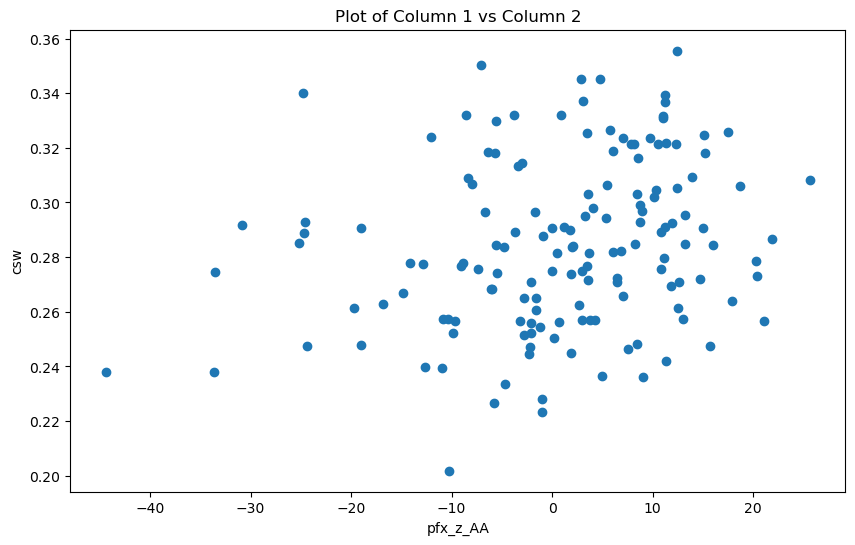

0.23989491612479152


In [113]:
# Assuming select is your DataFrame and you want to plot 'column1' against 'column2'
plt.figure(figsize=(10, 6))  # Optional: sets the figure size
plt.scatter(select['pfx_z_AA'], select['csw'])
plt.xlabel('pfx_z_AA')  # Label for the x-axis
plt.ylabel('csw')  # Label for the y-axis
plt.title('Plot of Column 1 vs Column 2')  # Title of the plot
plt.show()

correlation = select['pfx_z_AA'].corr(select['csw'])
print(correlation)

In [39]:
fastballs.groupby(by='rel_pos_z_bin').mean()

C:\Users\npacchioli\AppData\Local\Temp\ipykernel_940\3481786273.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fastballs.groupby(by='rel_pos_z_bin').mean()


,release_speed,release_pos_x,release_pos_z,batter,pitcher,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,hit_location,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,spin_axis,delta_home_win_exp,delta_run_exp,swstr,called_str,swing,ball,chase,csw,vy_f,t,vz_f,vaa
rel_pos_z_bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"(0.0, 4.0]",89.483062,0.415261,3.082394,635806.876221,651714.599349,NaN,NaN,NaN,NaN,8.009772,5.322581,0.912052,1.086319,2023.0,4.959283,4.906906,0.020228,2.989691,636419.025000,623271.924812,615845.905000,0.941368,7.302932,126.676667,121.425758,NaN,NaN,604461.858306,NaN,NaN,-2.035174,-129.643313,4.975222,5.487776,27.247360,-28.884257,3.358306,1.597850,169.363248,80.475527,25.485232,89.816803,2202.312704,6.742345,717888.027687,651714.599349,604461.858306,631293.415309,649125.304560,627962.532573,621305.807818,664726.280130,647223.351792,635831.843648,53.754511,0.344214,0.393673,0.390523,0.993421,0.202614,0.163399,3.295918,60.402280,3.201954,3.889251,3.978827,3.754072,4.114007,3.985342,3.915309,3.786645,4.114007,168.785016,0.002182,0.014822,0.099349,0.131922,0.511401,0.511401,0.171010,0.231270,-119.004553,0.391184,-6.336527,-3.037245
"(4.0, 4.25]",91.741388,-2.814928,4.149091,633817.547847,638043.148325,NaN,NaN,NaN,NaN,7.818182,4.773810,1.031100,1.078947,2023.0,-7.437129,8.987081,-0.059043,3.005215,626170.166667,630789.263158,620248.198830,1.076555,6.956938,134.074423,114.805000,NaN,NaN,618913.260766,NaN,NaN,8.409127,-133.166870,1.357477,-9.392825,27.262723,-23.701096,3.372943,1.604569,188.186567,81.518657,30.522388,92.150718,2280.700957,6.563636,717532.605263,638043.148325,618913.260766,637811.413876,650804.074163,638017.232057,644970.724880,672445.449761,654512.282297,654496.473684,53.936818,0.348962,0.398808,0.316981,0.990566,0.132075,0.113208,3.403846,56.272727,3.289474,3.492823,3.619617,3.760766,3.351675,3.636364,3.497608,3.782297,3.351675,230.511962,-0.000789,-0.000928,0.136364,0.119617,0.483254,0.488038,0.117225,0.255981,-122.820936,0.379781,-7.655815,-3.571186
"(4.25, 4.5]",91.977733,-2.369579,4.385789,633939.411336,639321.517409,NaN,NaN,NaN,NaN,7.485830,4.639535,0.927126,1.017814,2023.0,-7.203109,11.641360,-0.094721,2.916462,638455.559748,632089.915825,618895.225064,1.021053,7.841296,130.553544,117.967658,NaN,NaN,631328.164372,NaN,NaN,7.196864,-133.570564,0.018781,-8.949625,28.002174,-20.691770,3.374146,1.602130,182.221429,80.936038,30.658711,92.597245,2353.711741,6.784023,717591.024291,639321.517409,631328.164372,620420.498785,628683.596761,612980.541700,648387.188664,655761.863968,671119.381377,647286.569231,53.716283,0.336437,0.383595,0.280795,0.990066,0.145695,0.092715,3.367089,63.559514,3.107692,3.691498,3.751417,3.276113,4.166802,3.759514,3.703644,3.296356,4.166802,222.710931,-0.000343,-0.012445,0.150607,0.160324,0.510121,0.448583,0.136842,0.310931,-122.967296,0.378944,-7.837583,-3.650566
"(4.5, 4.75]",93.618210,-1.778884,4.644527,634671.590535,635345.810700,NaN,NaN,NaN,NaN,7.754630,4.997305,0.959877,0.918724,2023.0,-5.937407,12.972284,-0.032675,2.724928,634244.709677,636665.285141,632165.798092,1.062757,7.175926,134.120698,113.825814,NaN,NaN,609961.679012,NaN,NaN,5.746322,-136.085910,-1.621557,-7.607490,29.311021,-18.511729,3.353472,1.585628,188.265432,82.621094,29.196875,94.789352,2347.490741,6.977315,717465.243827,635345.81

In [133]:
grayson = df23.loc[df23['player_name'] == 'Rodriguez, Grayson']

In [142]:
x = pd.pivot_table(grayson,index= 'pitch_type', columns = 'Months', values = 'description',aggfunc = 'count')
x = x.reset_index()
x

x['Jul-Oct Percent'] = (x['Jul-Oct'] / x['Jul-Oct'].sum()) * 100
x['Mar-Jun Percent'] = (x['Mar-Jun'] / x['Mar-Jun'].sum()) * 100

x

Months,pitch_type,Jul-Oct,Mar-Jun,Jul-Oct Percent,Mar-Jun Percent
0,CH,284,187,23.374486,21.034871
1,CU,108,64,8.888889,7.199100
2,FC,12,109,0.987654,12.260967
3,FF,645,398,53.086420,44.769404
4,SL,166,131,13.662551,14.735658


In [146]:
y = pd.pivot_table(grayson,index= 'pitch_type', columns = 'Months', values = 'swstr')
y = y.reset_index()
y

Months,pitch_type,Jul-Oct,Mar-Jun
0,CH,0.176056,0.155080
1,CU,0.101852,0.078125
2,FC,0.083333,0.055046
3,FF,0.117829,0.135678
4,SL,0.186747,0.122137


In [143]:
grayson.groupby(by='pitch_type').mean()

C:\Users\npacchioli\AppData\Local\Temp\ipykernel_940\1304459755.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grayson.groupby(by='pitch_type').mean()


,release_speed,release_pos_x,release_pos_z,batter,pitcher,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,hit_location,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,spin_axis,delta_home_win_exp,delta_run_exp,swstr,called_str,swing,ball,chase,csw,vy_f,t,vz_f,vaa
pitch_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CH,83.903822,-2.462166,5.705499,631886.592357,680570.0,NaN,NaN,NaN,NaN,9.471338,4.690789,1.144374,1.225053,2023.0,-12.439236,2.684586,-0.200446,2.005499,641276.387097,619429.586207,625783.834437,0.978769,3.687898,129.715614,131.095439,NaN,NaN,629259.762208,NaN,NaN,7.407089,-121.983293,-2.634222,-11.791965,23.143403,-29.630850,3.377983,1.598153,108.796875,81.204167,5.281250,85.316136,1851.197452,7.172187,717493.602972,680570.0,629259.762208,658308.186837,637733.719745,659544.203822,643736.634820,664992.286624,643514.473461,620393.760085,53.329490,0.285351,0.296702,0.260303,1.0,0.169697,0.109091,2.938596,27.033970,3.609342,1.475584,1.575372,0.970276,2.080679,1.590234,1.490446,1.000000,2.080679,257.783439,-0.000212,-0.015898,0.167728,0.093418,0.577495,0.537155,0.208068,0.261146,-112.390516,0.414677,-14.919893,-7.561150
CU,79.941279,-2.296744,5.816860,641283.354651,680570.0,NaN,NaN,NaN,NaN,9.104651,4.656250,0.465116,0.813953,2023.0,9.135349,-12.643256,-0.040581,2.138837,658532.416667,644055.562500,625558.187500,0.889535,3.895349,126.595909,110.592273,NaN,NaN,634664.796512,NaN,NaN,3.590754,-116.305783,0.690520,6.155231,23.622085,-42.026329,3.339767,1.575233,136.282051,85.969231,2.435897,80.789535,2627.953488,7.067442,717371.988372,680570.0,634664.796512,657521.156977,637111.244186,656487.593023,647627.924419,666532.308140,646718.354651,605862.000000,53.433372,0.320636,0.396227,0.300000,1.0,0.111111,0.166667,3.136364,28.755814,2.459302,1.796512,1.470930,0.860465,2.406977,1.488372,1.825581,0.906977,2.406977,36.715116,-0.000674,0.017797,0.093023,0.273256,0.313953,0.517442,0.081395,0.366279,-105.982677,0.437288,-17.689981,-9.479700
FC,89.726446,-2.400992,5.834876,628777.760331,680570.0,NaN,NaN,NaN,NaN,8.851240,5.875000,1.016529,0.578512,2023.0,2.361322,9.133884,0.364463,2.784380,669130.250000,633753.615385,647707.595745,1.049587,2.685950,134.118333,120.662222,NaN,NaN,646133.727273,NaN,NaN,6.520120,-130.545165,-3.215526,0.882207,26.437600,-22.936638,3.415702,1.610083,153.725000,82.570000,11.925000,91.135537,2255.396694,7.060331,718169.958678,680570.0,646133.727273,661106.074380,630658.917355,678321.950413,626246.016529,670719.388430,657238.355372,643803.454545,53.436446,0.360000,0.450667,0.554348,1.0,0.130435,0.434783,3.388889,19.661157,2.743802,1.198347,1.793388,1.214876,1.776860,1.826446,1.231405,1.280992,1.776860,171.611570,0.001793,0.037033,0.057851,0.206612,0.388430,0.512397,0.074380,0.264463,-120.303535,0.387520,-12.116027,-5.759899
FF,97.362128,-2.406942,5.794199,629605.243528,680570.0,NaN,NaN,NaN,NaN,7.422819,5.423469,0.871524,0.904123,2023.0,-11.447977,15.852541,-0.093538,2.929664,633551.776316,622296.010526,630248.958466,0.960690,3.208054,133.348667,115.289400,NaN,NaN,630937.500479,NaN,NaN,8.529686,-141.444813,-5.249011,-14.794560,32.977752,-13.416143,3.391246,1.605235,188.634715,83.459269,24.579634,98.647172,2269.608821,7.145733,717446.558006,680570.0,630937.500479,658572.337488,637932.143816,655205.274209,646152.759348,665740.319271,647690.4